<a href="https://colab.research.google.com/github/Jax45/Deepfake-Detection/blob/main/Deepfake_Detection_Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5390 Deep Learning UMSL
## sp21 Semester Project
Jackson Hoenig

# Description



1. Watch the lecture in Module 4.
2. Practice this notebook. It demonstrates how to train a model by loading data from ImageDataGenerators.
2. Randomly split your data into training, development, and test set, i.e., put the images in three separate folders (for example, see mnist_png.tar.gz in the data folder). Note: The reason for randomly splitting ahead of time (and not at runtime) is 'reproducibility'.
2. Train your model using the training set, 'Earlystop' using the validation set, and evaluate on the test set. Hint: The trick is to create three sets of folders -- training, validation, and testing -- and then create three separate data generators.
2. Study the performance when the number of filters and layers are increased/changed
2. Plot your learning curves and include them in your report



#Initial Setup

##Imports

In [1]:
import requests, zipfile, io, os
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import callbacks
from keras.layers import Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


##Prevent Google Colab From Stalling

In [2]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


#Split the Training Data

In [3]:
print('Downloading and unzipping test file.')
r = requests.get('https://github.com/Jax45/Deepfake-Detection/raw/main/DeepfakeDataset-001.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
#create the directory paths
!mkdir SplitDataset
!mkdir SplitDataset/train
!mkdir SplitDataset/test
!mkdir SplitDataset/valid
!mkdir SplitDataset/train/real
!mkdir SplitDataset/train/fake
!mkdir SplitDataset/test/real
!mkdir SplitDataset/test/fake
!mkdir SplitDataset/valid/real
!mkdir SplitDataset/valid/fake

In [5]:

#save all real file names to list
import os
count = 0
realFileNames = list()
fakeFileNames = list()
for filename in os.listdir('/content/Real_Images'):
  realFileNames.append(filename)

#save all fake file names to list
for filename in os.listdir('/content/Fake_Images'):
  fakeFileNames.append(filename)



In [6]:
import random
import os
import imageio
#split real file names into
#train valid and test
random.shuffle(realFileNames)
count = 0
for file in realFileNames:
  if count < len(realFileNames) * 3 / 5: #first 60%
    # print("Train dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/train/real/' + file, imageio.imread('/content/Real_Images/' + file))

  elif count < len(realFileNames) * 4 / 5: #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/real/' + file, imageio.imread('/content/Real_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/real/' + file, imageio.imread('/content/Real_Images/' + file))

  count += 1;


With the fake images we need to make sure the same videos are kept together so they do not get split among the datasets. there are 8 videos so we will take the first 4 videos for training, the next 2 for validation and last 2 for test set.

In [7]:
count = 0
for file in fakeFileNames:
  if file.startswith('gen1') or file.startswith('gen3') or file.startswith('gen4') or file.startswith('gen5'): #first 60%
    print("Train dataset" + str(count) + file)
    imageio.imwrite('/content/SplitDataset/train/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  elif file.startswith('gen6') or file.startswith('gen7'): #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/fake/' + file, imageio.imread('/content/Fake_Images/' + file))
  
  count += 1;


Train dataset1gen5_frame185.jpg
Train dataset2gen5_frame70.jpg
Train dataset3gen4_frame415.jpg
Train dataset5gen5_frame110.jpg
Train dataset7gen1_frame175.jpg
Train dataset8gen4_frame440.jpg
Train dataset10gen3_frame15.jpg
Train dataset16gen5_frame40.jpg
Train dataset18gen4_frame100.jpg
Train dataset20gen4_frame10.jpg
Train dataset21gen4_frame240.jpg
Train dataset24gen1_frame105.jpg
Train dataset25gen4_frame35.jpg
Train dataset26gen1_frame45.jpg
Train dataset29gen3_frame90.jpg
Train dataset31gen3_frame125.jpg
Train dataset32gen1_frame65.jpg
Train dataset33gen3_frame50.jpg
Train dataset35gen4_frame375.jpg
Train dataset37gen3_frame145.jpg
Train dataset38gen4_frame355.jpg
Train dataset39gen5_frame95.jpg
Train dataset40gen4_frame315.jpg
Train dataset44gen1_frame190.jpg
Train dataset45gen4_frame335.jpg
Train dataset46gen4_frame210.jpg
Train dataset47gen4_frame370.jpg
Train dataset48gen4_frame290.jpg
Train dataset50gen5_frame180.jpg
Train dataset52gen3_frame100.jpg
Train dataset53gen3_frame2

In [8]:
base_dir = 'SplitDataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for s in os.listdir(base_dir):
  for origin in os.listdir(base_dir+'/'+s):
    print(base_dir+'/'+s+'/'+origin+': '+str(len(os.listdir(base_dir+'/'+s+'/'+origin))))
  print('-----')

SplitDataset/valid/real: 101
SplitDataset/valid/fake: 73
-----
SplitDataset/test/real: 100
SplitDataset/test/fake: 73
-----
SplitDataset/train/real: 302
SplitDataset/train/fake: 215
-----


## Create Data Generators

In [9]:
#get a validation set generator
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    brightness_range=[0.8,1.2],
    fill_mode='nearest' 
    )

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
class_dictionary = train_generator.class_indices
print(class_dictionary)

Found 517 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [10]:
#get a validation set generator
validate_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validate_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

Found 174 images belonging to 2 classes.


In [11]:
#get a test set generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical')

Found 173 images belonging to 2 classes.


#Train the models on the training set

In [30]:
#Make sure the Earlystop callback is used with the validation set
callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

model1 = Sequential()
model1.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model1.add( Flatten() )
model1.add( Dense( 2, activation = 'sigmoid' ) )
model1.summary()

model1.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )

history = model1.fit( train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1032256)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2064514   
Total params: 2,064,962
Trainable params: 2,064,962
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 10s 72ms/step - loss: 11.4917 - accuracy: 0.6565 - val_loss: 2.7398 - val_accuracy: 0.5747
Epoch 2/35
130/130 [==============================] - 9s 70ms/step - loss: 0.1852 - accuracy: 0.9305 - val_loss: 1.8026 - val_accuracy: 0.5805
Epoch 3/35
130/130 [==============================] - 9s 71ms/step - loss: 0.1280 - ac

In [32]:
model2 = Sequential()
model2.add( Conv2D( 128, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model2.add( MaxPool2D(4, 4) )
model2.add( Conv2D( 64, ( 3, 3 ), activation = 'relu' ) )
model2.add( MaxPool2D(4, 4) )
model2.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model2.add( MaxPool2D(4, 4) )
model2.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model2.add( Flatten() )
model2.add( Dense( 10, activation = 'relu' ) )
model2.add( Dense( 2, activation = 'sigmoid' ) )
model2.summary()
model2.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history2 = model2.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 16)         

In [33]:
model3 = Sequential()
model3.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model3.add( MaxPool2D(4, 4) )
model3.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model3.add( Flatten() )
model3.add( Dense( 2, activation = 'sigmoid' ) )
model3.summary()
model3.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history3 = model3.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_5 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 119074    
Total params: 124,594
Trainable params: 124,594
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 10s 71ms/step - loss: 0.6933 - accuracy: 0.6606 - val_loss: 

In [34]:
model4 = Sequential()
model4.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model4.add( MaxPool2D(4, 4) )
model4.add( Conv2D( 8, ( 3, 3 ), activation = 'relu' ) )
model4.add( Flatten() )
model4.add( Dense( 2, activation = 'sigmoid' ) )
model4.summary()
model4.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history4 = model4.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 8)         1160      
_________________________________________________________________
flatten_6 (Flatten)          (None, 29768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 59538     
Total params: 61,146
Trainable params: 61,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 10s 72ms/step - loss: 0.9144 - accuracy: 0.6652 - val_loss: 0.

In [35]:
model5 = Sequential()
model5.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model5.add( MaxPool2D(4, 4) )
model5.add( Flatten() )
model5.add( Dense( 2, activation = 'sigmoid' ) )
model5.summary()
model5.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history5 = model5.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 63504)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 127010    
Total params: 127,458
Trainable params: 127,458
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 10s 71ms/step - loss: 0.7911 - accuracy: 0.7019 - val_loss: 0.9047 - val_accuracy: 0.6379
Epoch 2/35
130/130 [==============================] - 9s 70ms/step - loss: 0.2386 - accuracy: 0.9073 -

In [36]:
model6 = Sequential()
model6.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model6.add( MaxPool2D(4, 4) )
model6.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model6.add( Flatten() )
model6.add( Dense( 8, activation = 'sigmoid' ) )
model6.add( Dense( 2, activation = 'sigmoid' ) )
model6.summary()
model6.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history6 = model6.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_8 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 476296    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 18        
Total params: 481,834
Trainable params: 481,834
Non-trainable params: 0
________________________________________________

In [37]:
model7 = Sequential()
model7.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model7.add( MaxPool2D(4, 4) )
model7.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model7.add( Flatten() )
model7.add( Dense( 2, activation = 'sigmoid' ) )
model7.summary()
model7.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history7 = model7.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 61, 16)        9232      
_________________________________________________________________
flatten_9 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 119074    
Total params: 130,098
Trainable params: 130,098
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 10s 73ms/step - loss: 0.7152 - accuracy: 0.6654 - val_loss: 

In [38]:
model8 = Sequential()
model8.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model8.add( MaxPool2D(4, 4) )
model8.add( Conv2D( 8, ( 3, 3 ), activation = 'relu' ) )
model8.add( Flatten() )
model8.add( Dense( 2, activation = 'sigmoid' ) )
model8.summary()
model8.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history8 = model8.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 61, 61, 8)         2312      
_________________________________________________________________
flatten_10 (Flatten)         (None, 29768)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 59538     
Total params: 62,746
Trainable params: 62,746
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 10s 71ms/step - loss: 0.6996 - accuracy: 0.6492 - val_loss: 0

In [40]:
model9 = Sequential()
model9.add(Dropout(0.2, input_shape=(256, 256, 3)))
model9.add( Conv2D( 8, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model9.add( MaxPool2D(4, 4) )
model9.add( Flatten() )
model9.add( Dense( 2, activation = 'sigmoid' ) )
model9.summary()
model9.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history9 = model9.fit(  validation_generator, validation_data=train_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 8)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 31752)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 63506     
Total params: 63,730
Trainable params: 63,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
44/44 [==============================] - 9s 195ms/step - loss: 0.8006 - accuracy: 0.7558 - val_loss: 0.9

#Evaluate on the test set

In [41]:
testing_loss, testing_acc =model1.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 1")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model2.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 2")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model3.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 3")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model4.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 4")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model5.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 5")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model6.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 6")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model7.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 7")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model8.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 8")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model9.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 9")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")

___________________________________
Model 1
testing_acc: 0.6242774724960327
testing_loss: 2.4832937717437744
___________________________________
Model 2
testing_acc: 0.5953757166862488
testing_loss: 3.1713857650756836
___________________________________
Model 3
testing_acc: 0.6358381509780884
testing_loss: 3.34318208694458
___________________________________
Model 4
testing_acc: 0.6358381509780884
testing_loss: 5.615783214569092
___________________________________
Model 5
testing_acc: 0.6358381509780884
testing_loss: 2.8252880573272705
___________________________________
Model 6
testing_acc: 0.6705202460289001
testing_loss: 0.8415911793708801
___________________________________
Model 7
testing_acc: 0.6358381509780884
testing_loss: 1.5424613952636719
___________________________________
Model 8
testing_acc: 0.6416184902191162
testing_loss: 0.8912026882171631
___________________________________
Model 9
testing_acc: 0.5433526039123535
testing_loss: 1.288326621055603


#Plot the curves

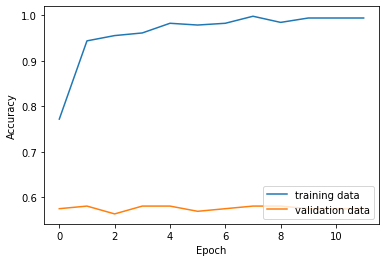

<Figure size 432x288 with 0 Axes>

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot1.png")

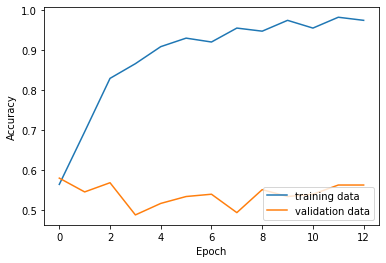

<Figure size 432x288 with 0 Axes>

In [43]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot2.png")

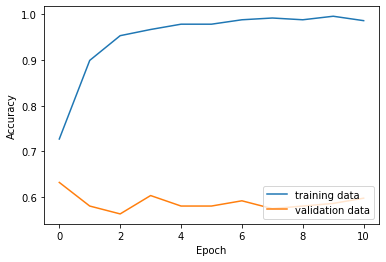

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot3.png")

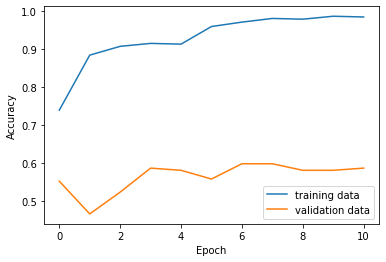

<Figure size 432x288 with 0 Axes>

In [45]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot4.png")

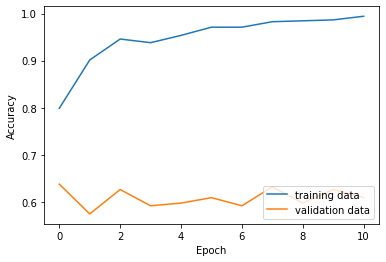

<Figure size 432x288 with 0 Axes>

In [46]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot5.png")

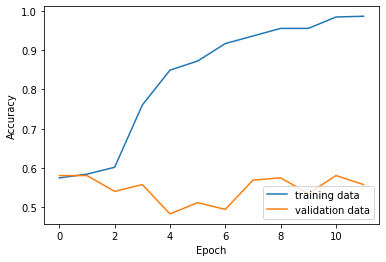

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot6.png")

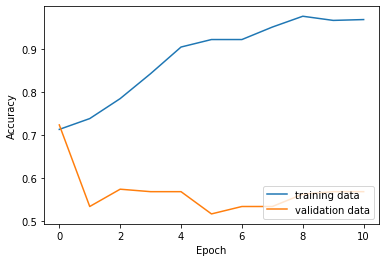

<Figure size 432x288 with 0 Axes>

In [48]:
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot7.png")

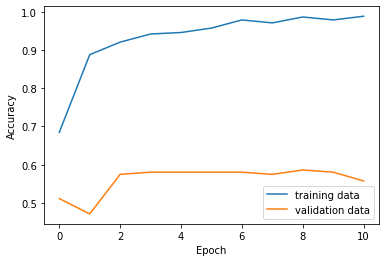

<Figure size 432x288 with 0 Axes>

In [49]:
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot8.png")

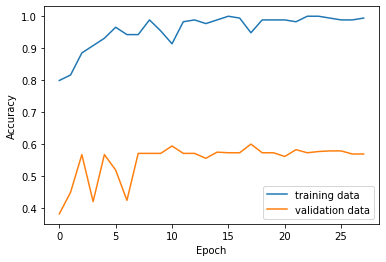

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot9.png")